# Financial Portfolio Optimization with amplpy
[![amplpyfinance_vs_amplpy.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/amplpyfinance/amplpyfinance_vs_amplpy.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/amplpyfinance/amplpyfinance_vs_amplpy.ipynb) [![Open In Deepnote](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?url=https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/amplpyfinance/amplpyfinance_vs_amplpy.ipynb) [![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/amplpyfinance/amplpyfinance_vs_amplpy.ipynb) [![Open In Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/amplpyfinance/amplpyfinance_vs_amplpy.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/amplpyfinance/amplpyfinance_vs_amplpy.ipynb) [![Powered by AMPL](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/amplpyfinance/amplpyfinance_vs_amplpy.ipynb)](https://ampl.com)

Description: Financial Portfolio Optimization with amplpy and amplpyfinance

Tags: amplpy, amplpyfinance, finance

Notebook author: Filipe Brandão <<fdabrandao@gmail.com>>

Model author: Harry Markowitz

References:
1. amplpy: https://amplpy.readthedocs.io/
2. amplpyfinance: https://amplpyfinance.readthedocs.io/
3. Cornuejols, G., and Tütüncü, R. (2018). *Optimization Methods in Finance* (2nd edition): Bond Dedication example. Cambridge University Press.

In [1]:
# Install dependencies
%pip install -q amplpy pandas matplotlib yfinance amplpyfinance

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Downloading data and callculate `mu` and `S`

In [3]:
from pypfopt import expected_returns, risk_models
import yfinance as yf

tickers = [
    "MSFT",
    "AMZN",
    "KO",
    "MA",
    "COST",
    "LUV",
    "XOM",
    "PFE",
    "JPM",
    "UNH",
    "ACN",
    "DIS",
    "GILD",
    "F",
    "TSLA",
]

ohlc = yf.download(tickers, period="max", auto_adjust=True)
prices = ohlc["Close"].dropna(how="all")
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

[*********************100%***********************]  15 of 15 completed
/usr/local/lib/python3.11/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


## Minimize volatility

Using `EfficientFrontierWithAMPL.min_volatility`:

In [4]:
from amplpyfinance import EfficientFrontierWithAMPL

ef = EfficientFrontierWithAMPL(None, S, weight_bounds=(0, 1), solver="gurobi")
ef.min_volatility()
_, sigma1, _ = ef.portfolio_performance(verbose=True)

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.0152842978
0 simplex iterations
11 barrier iterations
Annual volatility: 12.4%


Using `amplpy` directly:

In [5]:
from amplpy import AMPL
import pandas as pd

ampl = AMPL()
ampl.eval(
    r"""
    set A ordered;
    param S{A, A};
    param lb default 0;
    param ub default 1;
    var w{A} >= lb <= ub;
    minimize portfolio_variance:
        sum {i in A, j in A} w[i] * S[i, j] * w[j];
    s.t. portfolio_weights:
        sum {i in A} w[i] = 1;
    """
)
ampl.set["A"] = ef.tickers
ampl.param["S"] = pd.DataFrame(ef.cov_matrix, index=ef.tickers, columns=ef.tickers)
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved", ampl.solve_result
sigma = ampl.get_value("sqrt(sum {i in A, j in A} w[i] * S[i, j] * w[j])")
print(f"Annual volatility: {sigma*100:.1f}%")

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.0152842978
0 simplex iterations
11 barrier iterations
Annual volatility: 12.4%


<Axes: >

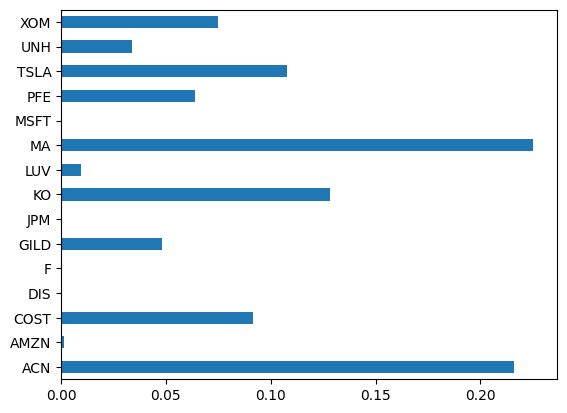

In [6]:
pd.Series(ef.clean_weights()).plot.barh()

## Maximize return for a target risk

Using `EfficientFrontierWithAMPL.efficient_risk`:

In [7]:
from amplpyfinance import EfficientFrontierWithAMPL

ef = EfficientFrontierWithAMPL(mu, S, solver="gurobi")
ef.efficient_risk(target_volatility=0.15)
mu1, sigma1, sharpe1 = ef.portfolio_performance(verbose=True)

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.2665958884
0 simplex iterations
8 barrier iterations
Expected annual return: 26.7%
Annual volatility: 15.0%
Sharpe Ratio: 1.64


Using `amplpy` directly:

In [8]:
from amplpy import AMPL

ampl = AMPL()
ampl.eval(
    r"""
    param target_volatility;
    param market_neutral default 0;
    set A ordered;
    param S{A, A};
    param mu{A} default 0;

    param lb default 0;
    param ub default 1;
    var w{A} >= lb <= ub;
    maximize portfolio_return:
        sum {i in A} mu[i] * w[i];
    s.t. portfolio_variance:
        sum {i in A, j in A} w[i] * S[i, j] * w[j] <= target_volatility^2;
    s.t. portfolio_weights:
        sum {i in A} w[i] = if market_neutral then 0 else 1;
    """
)
ampl.set["A"] = ef.tickers
ampl.param["S"] = pd.DataFrame(ef.cov_matrix, index=ef.tickers, columns=ef.tickers)
ampl.param["mu"] = ef.expected_returns
ampl.param["target_volatility"] = 0.15
ampl.param["market_neutral"] = False
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved", ampl.solve_result
sigma2 = ampl.get_value("sqrt(sum {i in A, j in A} w[i] * S[i, j] * w[j])")
mu2 = ampl.get_value("sum {i in A} mu[i] * w[i]")
risk_free_rate = 0.02
sharpe2 = (mu2 - risk_free_rate) / sigma2
print(f"Expected annual return: {mu2*100:.1f}%")
print(f"Annual volatility: {sigma2*100:.1f}%")
print(f"Sharpe Ratio: {sharpe2:.2f}")

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.2665958884
0 simplex iterations
8 barrier iterations
Expected annual return: 26.7%
Annual volatility: 15.0%
Sharpe Ratio: 1.64


<Axes: >

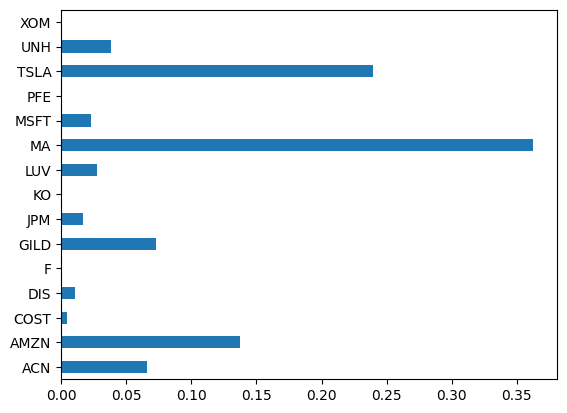

In [9]:
pd.Series(ef.clean_weights()).plot.barh()

## Minimizing volatility for a given target return

Using `EfficientFrontierWithAMPL.efficient_return`:

In [10]:
from amplpyfinance import EfficientFrontierWithAMPL

ef = EfficientFrontierWithAMPL(mu, S, weight_bounds=(None, None), solver="gurobi")
ef.efficient_return(target_return=0.07, market_neutral=True)
mu1, sigma1, sharpe1 = ef.portfolio_performance(verbose=True)

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.8130032838
1 simplex iteration
Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.008548381941
0 simplex iterations
9 barrier iterations
Expected annual return: 7.0%
Annual volatility: 9.2%
Sharpe Ratio: 0.54


Using `amplply` directly:

In [11]:
from amplpy import AMPL

ampl = AMPL()
ampl.eval(
    r"""
    param target_return;
    param market_neutral default 0;

    set A ordered;
    param S{A, A};
    param mu{A} default 0;

    param lb default 0;
    param ub default 1;
    var w{A} >= lb <= ub;

    minimize portfolio_variance:
        sum {i in A, j in A} w[i] * S[i, j] * w[j];
    s.t. portfolio__return:
        sum {i in A} mu[i] * w[i] >= target_return;
    s.t. portfolio_weights:
        sum {i in A} w[i] = if market_neutral then 0 else 1;
    """
)
ampl.set["A"] = ef.tickers
ampl.param["S"] = pd.DataFrame(ef.cov_matrix, index=ef.tickers, columns=ef.tickers)
ampl.param["mu"] = ef.expected_returns
ampl.param["target_return"] = 0.07
ampl.param["market_neutral"] = True
ampl.param["lb"] = -1
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved", ampl.solve_result
sigma2 = ampl.get_value("sqrt(sum {i in A, j in A} w[i] * S[i, j] * w[j])")
mu2 = ampl.get_value("sum {i in A} mu[i] * w[i]")
risk_free_rate = 0.02
sharpe2 = (mu2 - risk_free_rate) / sigma2
print(f"Expected annual return: {mu2*100:.1f}%")
print(f"Annual volatility: {sigma2*100:.1f}%")
print(f"Sharpe Ratio: {sharpe2:.2f}")

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.008548381941
0 simplex iterations
9 barrier iterations
Expected annual return: 7.0%
Annual volatility: 9.2%
Sharpe Ratio: 0.54


<Axes: >

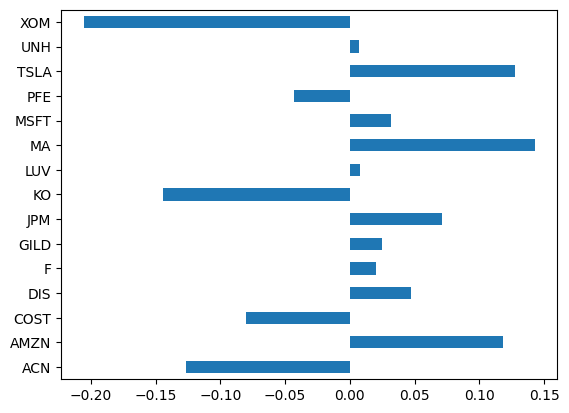

In [12]:
pd.Series(ef.clean_weights()).plot.barh()

## Maximize the Sharpe Ratio

Using `EfficientFrontierWithAMPL.max_sharpe`:

In [13]:
from amplpyfinance import EfficientFrontierWithAMPL

ef = EfficientFrontierWithAMPL(mu, S, solver="gurobi")
ef.max_sharpe()
mu1, sigma1, sharpe1 = ef.portfolio_performance(verbose=True)

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.3572734783
0 simplex iterations
13 barrier iterations
Expected annual return: 24.7%
Annual volatility: 13.6%
Sharpe Ratio: 1.67


Using `amplpy` directly:

In [14]:
from amplpy import AMPL

ampl = AMPL()
ampl.eval(
    r"""
    param risk_free_rate default 0.02;

    set A ordered;
    param S{A, A};
    param mu{A} default 0;

    var k >= 0;
    var z{i in A} >= 0;  # scaled weights
    var w{i in A} = z[i] / k;

    minimize portfolio_sharpe:
        sum {i in A, j in A} z[i] * S[i, j] * z[j];
    s.t. muz:
        sum {i in A} (mu[i] - risk_free_rate) * z[i] = 1;
    s.t. portfolio_weights:
        sum {i in A}  z[i] = k;
    """
)
ampl.set["A"] = ef.tickers
ampl.param["S"] = pd.DataFrame(ef.cov_matrix, index=ef.tickers, columns=ef.tickers)
ampl.param["mu"] = ef.expected_returns
ampl.option["solver"] = "gurobi"
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved", ampl.solve_result
sigma2 = ampl.get_value("sqrt(sum {i in A, j in A} w[i] * S[i, j] * w[j])")
mu2 = ampl.get_value("sum {i in A} mu[i] * w[i]")
risk_free_rate = 0.02
sharpe2 = (mu2 - risk_free_rate) / sigma2
print(f"Expected annual return: {mu2*100:.1f}%")
print(f"Annual volatility: {sigma2*100:.1f}%")
print(f"Sharpe Ratio: {sharpe2:.2f}")

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.357273479
0 simplex iterations
11 barrier iterations
Expected annual return: 24.7%
Annual volatility: 13.6%
Sharpe Ratio: 1.67


<Axes: >

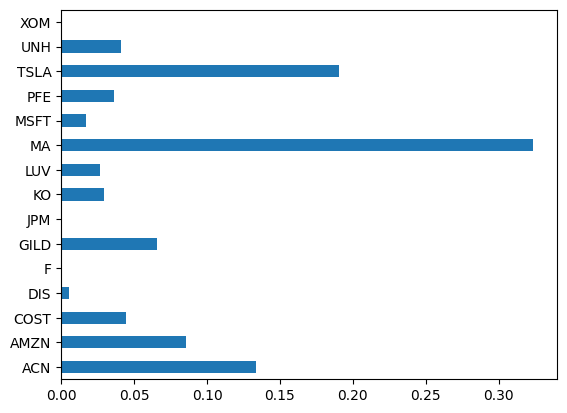

In [15]:
pd.Series(ef.clean_weights()).plot.barh()

## Maximize quadratic utility

Quadratic utility: $\max_w w^T \mu - \frac \delta 2 w^T \Sigma w$

Using `EfficientFrontierWithAMPL.max_quadratic_utility`:

In [16]:
ef = EfficientFrontierWithAMPL(mu, S, weight_bounds=(0, 1), solver="gurobi")
ef.max_quadratic_utility(risk_aversion=2, market_neutral=False)
mu1, sigma1, sharpe1 = ef.portfolio_performance(verbose=True)

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.2651576327
0 simplex iterations
10 barrier iterations
Expected annual return: 31.7%
Annual volatility: 22.7%
Sharpe Ratio: 1.31


Using `amplpy` directly:

In [17]:
from amplpy import AMPL

ampl = AMPL()
ampl.eval(
    r"""
    param risk_aversion default 1;
    param market_neutral default 0;

    set A ordered;
    param S{A, A};
    param mu{A} default 0;

    param lb default 0;
    param ub default 1;
    var w{A} >= lb <= ub;

    maximize quadratic_utility:
        sum {i in A} mu[i] * w[i]
        - 0.5 * risk_aversion * sum {i in A, j in A} w[i] * S[i, j] * w[j];
    s.t. portfolio_weights:
        sum {i in A} w[i] = if market_neutral then 0 else 1;
    """
)
ampl.set["A"] = ef.tickers
ampl.param["S"] = pd.DataFrame(ef.cov_matrix, index=ef.tickers, columns=ef.tickers)
ampl.param["mu"] = ef.expected_returns
ampl.param["risk_aversion"] = 2
ampl.param["market_neutral"] = False
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved", ampl.solve_result
sigma2 = ampl.get_value("sqrt(sum {i in A, j in A} w[i] * S[i, j] * w[j])")
mu2 = ampl.get_value("sum {i in A} mu[i] * w[i]")
risk_free_rate = 0.02
sharpe2 = (mu2 - risk_free_rate) / sigma2
print(f"Expected annual return: {mu2*100:.1f}%")
print(f"Annual volatility: {sigma2*100:.1f}%")
print(f"Sharpe Ratio: {sharpe2:.2f}")

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.2651576327
0 simplex iterations
10 barrier iterations
Expected annual return: 31.7%
Annual volatility: 22.7%
Sharpe Ratio: 1.31


<Axes: >

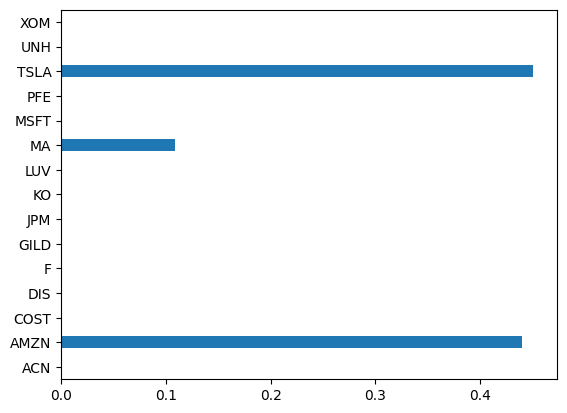

In [18]:
pd.Series(ef.clean_weights()).plot.barh()

## Maximize return for a target risk with sector constraints

Using `EfficientFrontierWithAMPL.add_sector_constraints`:

In [19]:
sector_mapper = {
    "MSFT": "Tech",
    "AMZN": "Consumer Discretionary",
    "KO": "Consumer Staples",
    "MA": "Financial Services",
    "COST": "Consumer Staples",
    "LUV": "Aerospace",
    "XOM": "Energy",
    "PFE": "Healthcare",
    "JPM": "Financial Services",
    "UNH": "Healthcare",
    "ACN": "Misc",
    "DIS": "Media",
    "GILD": "Healthcare",
    "F": "Auto",
    "TSLA": "Auto",
}

sector_lower = {
    "Consumer Staples": 0.1,  # at least 10% to staples
    "Tech": 0.05,  # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {"Tech": 0.2, "Aerospace": 0.1, "Energy": 0.1, "Auto": 0.15}

In [20]:
ef = EfficientFrontierWithAMPL(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(target_volatility=0.15)
mu1, sigma1, sharpe1 = ef.portfolio_performance(verbose=True)

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.2618079408
0 simplex iterations
7 barrier iterations
Expected annual return: 26.2%
Annual volatility: 15.0%
Sharpe Ratio: 1.61


Using `amplpy` directly:

In [21]:
from amplpy import AMPL

ampl = AMPL()
ampl.eval(
    r"""
    param target_volatility;
    param market_neutral default 0;

    set A ordered;
    param S{A, A};
    param mu{A} default 0;

    param lb default 0;
    param ub default 1;
    var w{A} >= lb <= ub;

    maximize portfolio_return:
        sum {i in A} mu[i] * w[i];
    s.t. portfolio_variance:
        sum {i in A, j in A} w[i] * S[i, j] * w[j] <= target_volatility^2;
    s.t. portfolio_weights:
        sum {i in A} w[i] = 1;

    set SECTORS default {};
    set SECTOR_MEMBERS{SECTORS};
    param sector_lower{SECTORS} default -Infinity;
    param sector_upper{SECTORS} default Infinity;
    s.t. sector_constraints_lower{s in SECTORS: sector_lower[s] != -Infinity}:
        sum {i in SECTOR_MEMBERS[s]} w[i] >= sector_lower[s];
    s.t. sector_constraints_upper{s in SECTORS: sector_upper[s] != Infinity}:
        sum {i in SECTOR_MEMBERS[s]} w[i] <= sector_upper[s];
    """
)
ampl.set["A"] = ef.tickers
ampl.param["S"] = pd.DataFrame(ef.cov_matrix, index=ef.tickers, columns=ef.tickers)
ampl.param["mu"] = ef.expected_returns
ampl.param["target_volatility"] = 0.15
sectors = set(sector_mapper.values())
ampl.set["SECTORS"] = sectors
for sector in sectors:
    ampl.set["SECTOR_MEMBERS"][sector] = [
        ticker for ticker, s in sector_mapper.items() if s == sector
    ]
ampl.param["sector_lower"] = sector_lower
ampl.param["sector_upper"] = sector_upper
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved", ampl.solve_result
sigma2 = ampl.get_value("sqrt(sum {i in A, j in A} w[i] * S[i, j] * w[j])")
mu2 = ampl.get_value("sum {i in A} mu[i] * w[i]")
risk_free_rate = 0.02
sharpe2 = (mu2 - risk_free_rate) / sigma2
print(f"Expected annual return: {mu2*100:.1f}%")
print(f"Annual volatility: {sigma2*100:.1f}%")
print(f"Sharpe Ratio: {sharpe2:.2f}")

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.2618079408
0 simplex iterations
7 barrier iterations
Expected annual return: 26.2%
Annual volatility: 15.0%
Sharpe Ratio: 1.61


<Axes: >

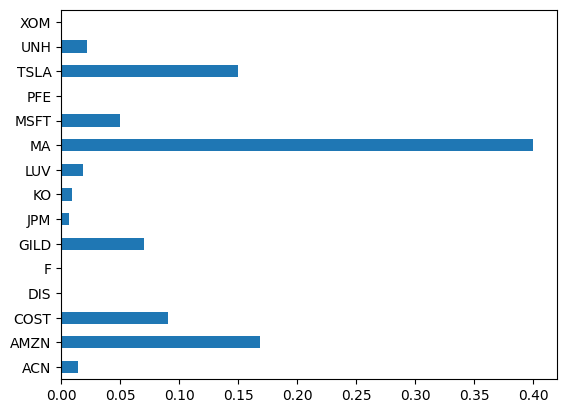

In [22]:
pd.Series(ef.clean_weights()).plot.barh()

## Maximize return for a target risk with cardinality constraints

Using `EfficientFrontierWithAMPL`:

In [23]:
ef = EfficientFrontierWithAMPL(mu, S)
ef.ampl.param["card_ub"] = 3
ef.efficient_risk(target_volatility=0.15)
mu1, sigma1, sharpe1 = ef.portfolio_performance(verbose=True)

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.2488933957
1085 simplex iterations
216 branching nodes
absmipgap=2.16157e-05, relmipgap=8.68473e-05
Expected annual return: 24.9%
Annual volatility: 15.0%
Sharpe Ratio: 1.53


Using `amplpy` directly:

In [24]:
from amplpy import AMPL

ampl = AMPL()
ampl.eval(
    r"""
    param target_volatility;
    param market_neutral default 0;

    set A ordered;
    param S{A, A};
    param mu{A} default 0;

    param lb default 0;
    param ub default 1;
    var w{A} >= lb <= ub;

    maximize portfolio_return:
        sum {i in A} mu[i] * w[i];
    s.t. portfolio_variance:
        sum {i in A, j in A} w[i] * S[i, j] * w[j] <= target_volatility^2;
    s.t. portfolio_weights:
        sum {i in A} w[i] = if market_neutral then 0 else 1;

    var y{A} binary;
    s.t. w_lower{i in A}:
        lb * y[i] <= w[i];
    s.t. w_upper{i in A}:
        w[i] <= ub * y[i];

    param card_ub default Infinity;
    s.t. card_limit:
        sum {i in A} y[i] <= card_ub;
    """
)
ampl.set["A"] = ef.tickers
ampl.param["S"] = pd.DataFrame(ef.cov_matrix, index=ef.tickers, columns=ef.tickers)
ampl.param["mu"] = ef.expected_returns
ampl.param["card_ub"] = 3
ampl.param["target_volatility"] = 0.15
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved", ampl.solve_result
sigma2 = ampl.get_value("sqrt(sum {i in A, j in A} w[i] * S[i, j] * w[j])")
mu2 = ampl.get_value("sum {i in A} mu[i] * w[i]")
risk_free_rate = 0.02
sharpe2 = (mu2 - risk_free_rate) / sigma2
print(f"Expected annual return: {mu2*100:.1f}%")
print(f"Annual volatility: {sigma2*100:.1f}%")
print(f"Sharpe Ratio: {sharpe2:.2f}")

Gurobi 12.0.1: Gurobi 12.0.1: optimal solution; objective 0.2488933957
1085 simplex iterations
216 branching nodes
absmipgap=2.16157e-05, relmipgap=8.68473e-05
Expected annual return: 24.9%
Annual volatility: 15.0%
Sharpe Ratio: 1.53


<Axes: >

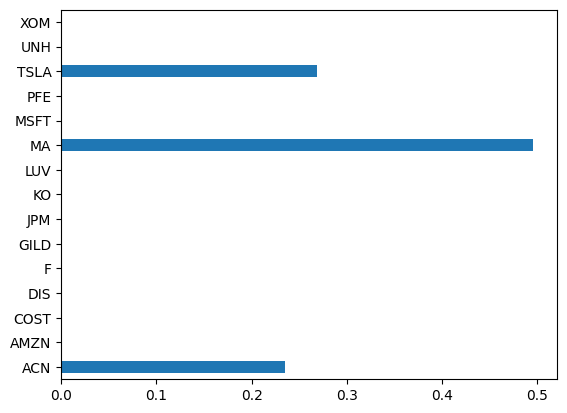

In [25]:
pd.Series(ef.clean_weights()).plot.barh()